__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 16 июл 2024 13:04:45 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

41160

,title,address,latitude,longitude,priceM,dt
17356,"1-к. квартира, 38,2 м², 7/8 эт.","судак,жк «долина роз» кв-л долина роз,1 оч.",44.87,34.95,9.75,2024-06-14
2227,"1-комн. квартира, 32,5 м², 7/10 этаж","севастополь,р-н гагаринский,мкр.5-й,улица тараса шевченко,50",44.57,33.46,5.70,2024-07-16
7100,"2-комн. квартира, 38 м², 2/3 этаж","севастополь,р-н гагаринский,переулок 1-й папоротниковый,17",44.58,33.45,4.20,2024-06-11


In [4]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [5]:
df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
display( len(df_) )
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

108483

85199

,title,address,latitude,longitude,priceM,dt,url
42692,"доля в 2-к. квартире, 62 м², 5/5 эт.","Севастополь, улица Молодых Строителей, 4",44.580418,33.464715,3.99,2022-09-16,https://avito.ru/2508981119
28552,"3-к. апартаменты, 188,5 м², 4/9 эт.","Севастополь,Севастопольская зона ЮБК, 20А",44.412895,33.713584,36.59,2022-09-08,https://avito.ru/2210471947
80350,"1-к. квартира, 60 м², 8/10 эт.","Севастополь, улица Генерала Крейзера, д. 8, корп. 5",44.602916,33.512819,8.67,2023-01-10,https://avito.ru/2468729235


In [6]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

    df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

    df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
    df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

    df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
    df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

    df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
    df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

    df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
    df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

    df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
    df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
    df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

    df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
    df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

    df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

    df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
    df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
    df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
    df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'
    df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [7]:
df_ = address_filter(df_)
history_date = df_['dt'].max()
df = pd.concat([df,df_])
display( len(df) )
del df_

126344

----

In [8]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

In [9]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

126344

126344

----

In [10]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

126344

86812

86812

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
23697,"3-к. квартира, 69,6 м², 3/5 эт.","севастополь,село песчаное,улица комарова,14",44.84,33.61,7.10,2024-06-17,https://www.avito.ru/3863750503
39228,"1-к. квартира, 20,2 м², 2/5 эт.","севастополь,улица николая музыки,78",44.58,33.52,2.90,2024-06-13,https://www.avito.ru/3897333706
56770,"2-к. квартира, 44 м², 11/11 эт.","Севастополь,Столетовский проспект , 29",44.58,33.46,7.59,2022-10-08,https://avito.ru/2298680474


---

In [12]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
# display( dt_min,history_date,dt_max )
print( dt_min,' : ',dt_max )

2022-08-26  :  2024-07-16


In [13]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [14]:
# display( len(gdf_history) )
display( len(gdf) )

86812

In [15]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    .drop_duplicates(['dt','url'])
    .reset_index(drop=True)
)
display( len(gdf) )

86812

86812

In [16]:
# gdf.columns

In [17]:
# цена за квадратный метр (тыс.руб.)
gdf['price_area_K'] = (gdf['price']/gdf['area'])/1_000

# общая статистика

In [18]:
gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [19]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [20]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [21]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [22]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  \
place      nrooms week                                                      
sevastopol 1      2022-08-22/2022-08-28 1203.00  6.26 1.91 1.59 2.31 3.70   
                  2022-08-29/2022-09-04 4734.00  6.31 1.90 1.30 2.75 3.72   
                  2022-09-05/2022-09-11 4499.00  6.32 1.91 1.60 2.80 3.72   
                  2022-09-12/2022-09-18 4435.00  6.32 1.89 1.60 2.20 3.70   
                  2022-09-19/2022-09-25 2346.00  6.29 1.92 1.35 2.25 3.60   
...                                         ...   ...  ...  ...  ...  ...   
sudak      3      2024-06-10/2024-06-16  112.00 11.15 5.97 3.50 3.50 3.60   
                  2024-06-17/2024-06-23   56.00 11.14 5.98 3.50 3.50 3.60   
                  2024-06-24/2024-06-30   32.00 10.68 5.77 3.60 3.72 4.17   
                  2024-07-08/2024-07-14   39.00 10.09 5.25 3.60 3.75 4.27   
                  2024-07-15/2024-07-21   38.00 10.30 5.24 3.60 3.75 4.21   

                                         10%  25%  50%   75%   90%   95%   max  
place      nrooms week                                                          
sevastopol 1      2022-08-22/2022-08-28 4.07 5.00 6.00  7.30  8.50  9.54 18.50  
                  2022-08-29/2022-09-04 4.16 5.02 6.00  7.40  8.60  9.70 18.50  
                  2022-09-05/2022-09-11 4.15 5.05 6.00  7.40  8.70  9.78 18.50  
                  2022-09-12/2022-09-18 4.24 5.10 6.00  7.35  8.55  9.70 18.50  
                  2022-09-19/2022-09-25 4.20 5.10 6.00  7.30  8.50  9.70 18.50  
...                                      ...  ...  ...   ...   ...   ...   ...  
sudak      3      2024-06-10/2024-06-16 4.07 8.50 9.60 13.00 21.49 23.63 30.00  
                  2024-06-17/2024-06-23 4.35 8.50 9.60 13.00 18.74 23.63 30.00  
                  2024-06-24/2024-06-30 4.70 7.58 9.70 12.20 15.27 22.83 30.00  
                  2024-07-08/2024-07-14 4.65 7.00 9.50 10.82 13.84 22.28 30.00  
                  2024-07-15/2024-07-21 4.62 8.12 9.68 10.50 15.01 22.30 30.00  

[75 rows x 13 columns]

In [23]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

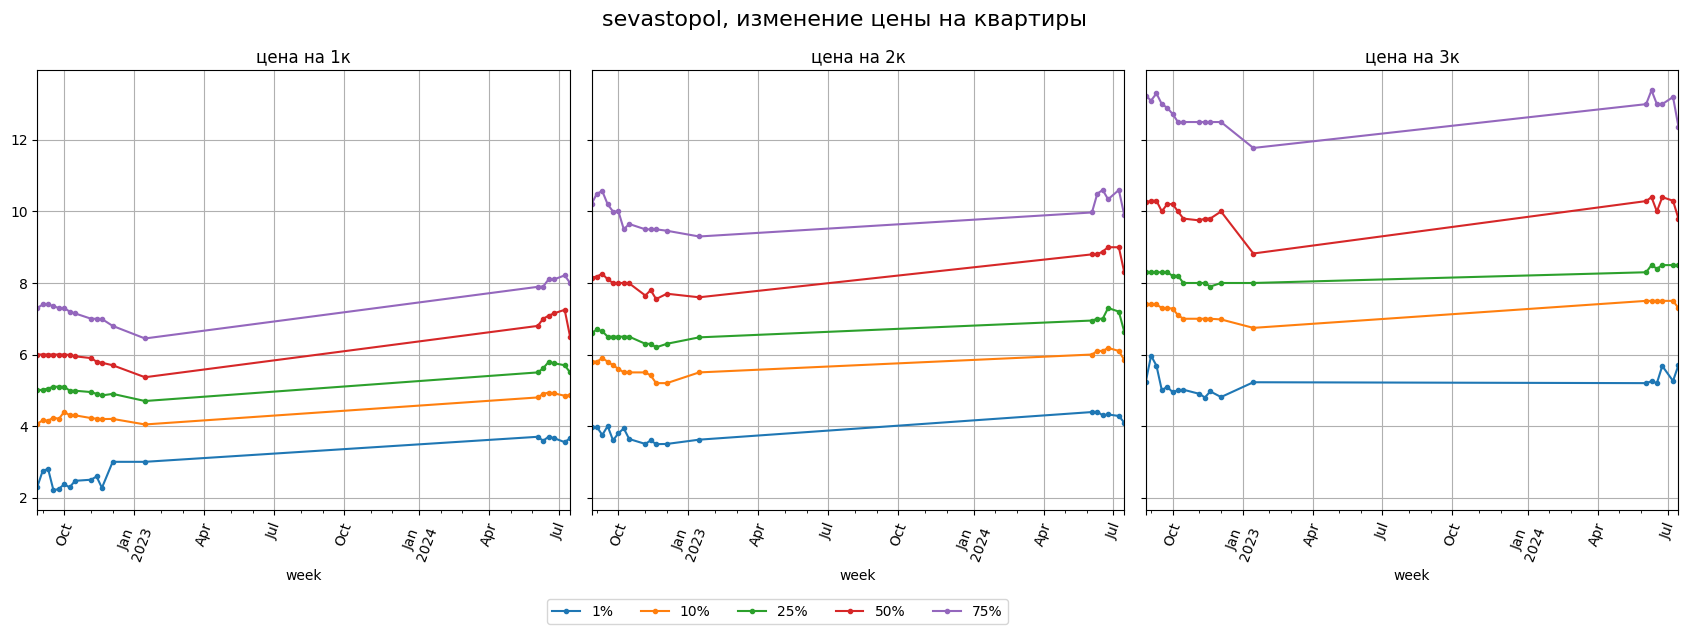

In [24]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

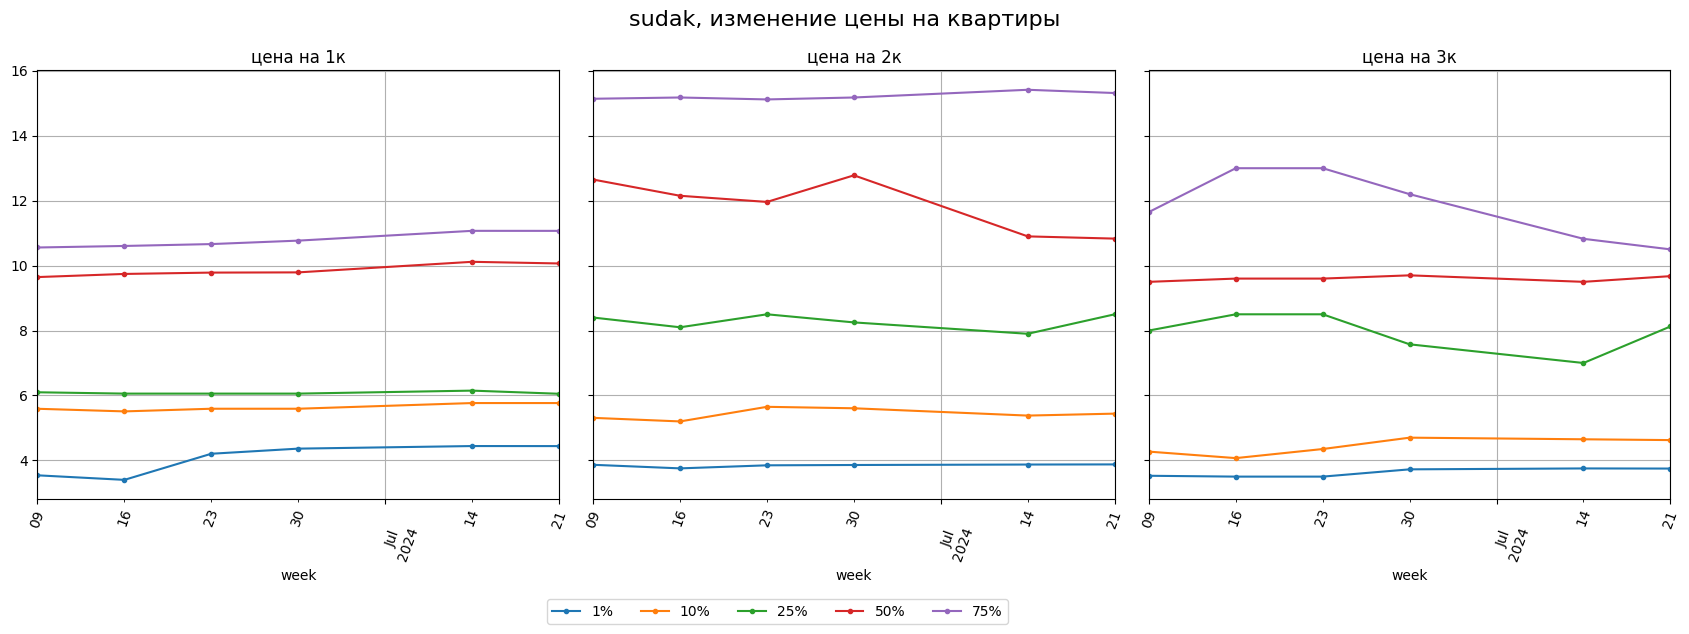

In [25]:
# history_date

place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [26]:
# sorted(gdf['dt'].unique() )

In [27]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

86812

991

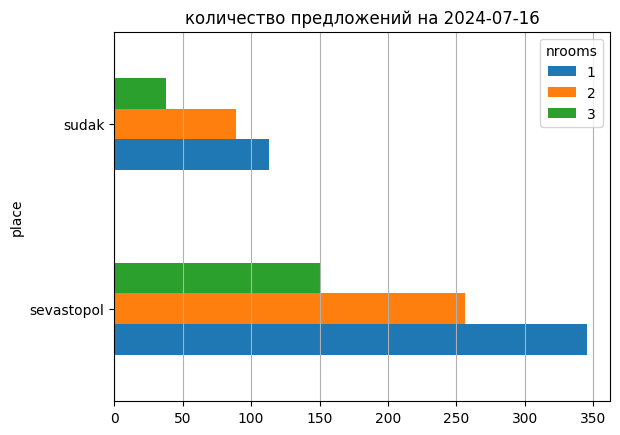

In [28]:
(
gdf_last
.drop_duplicates('url')
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str(dt_now))
.grid(axis='x')    
)

In [29]:
(
    gdf_last
    .drop_duplicates('url')
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      345.00  6.93 2.03 2.50 3.66 4.50 4.87 5.50  6.50  8.00   
           2      256.00  8.75 3.39 3.35 4.10 5.55 5.85 6.64  8.30  9.90   
           3      150.00 10.99 4.13 4.20 5.70 7.00 7.30 8.50  9.80 12.38   
sudak      1      113.00  9.11 2.73 3.30 4.44 5.21 5.77 6.05 10.07 11.07   
           2       89.00 12.16 5.46 3.70 3.88 4.50 5.44 8.50 10.83 15.32   
           3       38.00 10.30 5.24 3.60 3.75 4.21 4.62 8.12  9.68 10.50   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.34 10.46 16.23  
           2      12.55 14.05 41.00  
           3      16.53 19.89 29.00  
sudak      1      11.35 11.86 18.00  
           2      20.16 23.07 25.15  
           3      15.01 22.30 30.00

In [30]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

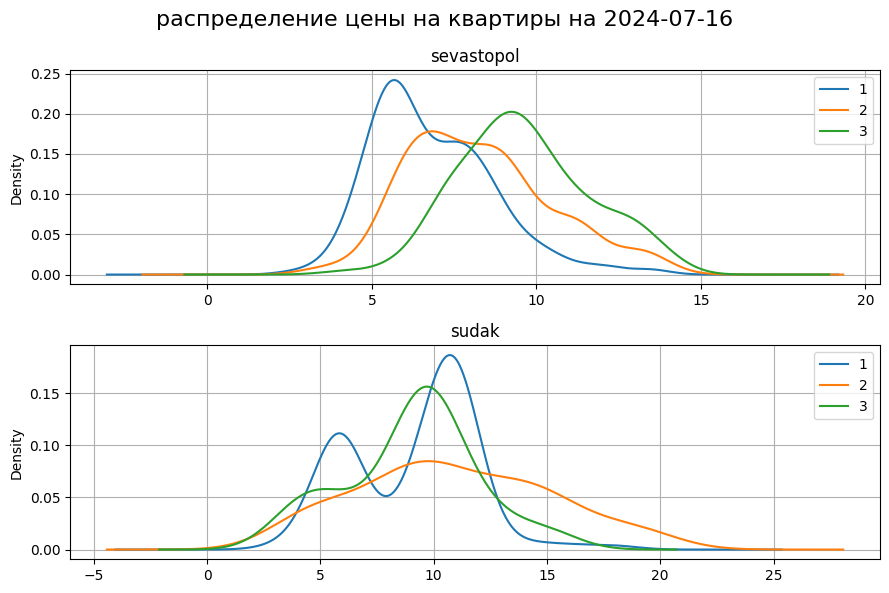

In [31]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6) )
for i,p in enumerate(places): 
    (
        gdf_last
        .drop_duplicates('url')
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [32]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [33]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [34]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [35]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )

In [36]:
gdf_last.columns #[['']]

Index(['url', 'place', 'title', 'subtitle', 'price', 'address', 'description',
       'ts', 'nrooms', 'floor', 'nfloors', 'area', 'is_studio', 'is_apartment',
       'is_part', 'is_auction', 'is_openspace', 'is_roof', 'is_SNT', 'priceM',
       'is_last_floor', 'address_orig', 'place_', 'latitude', 'longitude',
       'dt', 'month', 'week', 'geometry', 'price_area_K'],
      dtype='object')

In [38]:
# медиана цены за квадратный метр (тыс.руб.)

grid_values = ( 
    grid
    .sjoin( gdf_last.drop_duplicates('url').query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['price_area_K']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

## Судак

In [39]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [40]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=9 )

In [41]:
# медиана цены за квадратный метр (тыс.руб.)
grid_values = ( 
    grid
    .sjoin( 
        gdf_last
        .drop_duplicates('url')
        .query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['price_area_K']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('price_area_K',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [42]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [43]:
frames.explore('area_name', legend=True)

In [44]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
]

In [45]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [46]:
# фильтруем данные по области
gdf_last_local = gdf_last.drop_duplicates('url').sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

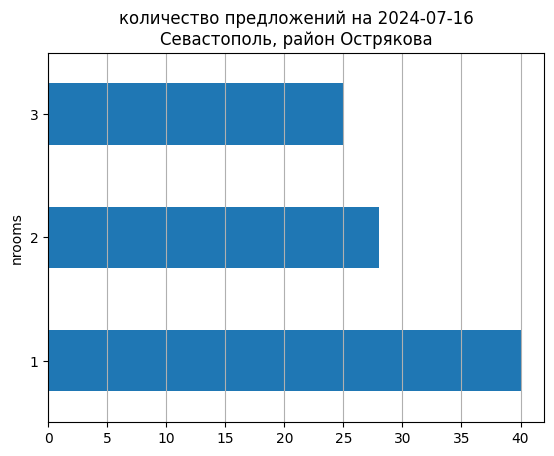

In [47]:
(
    gdf_last_local
    .drop_duplicates('url')
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

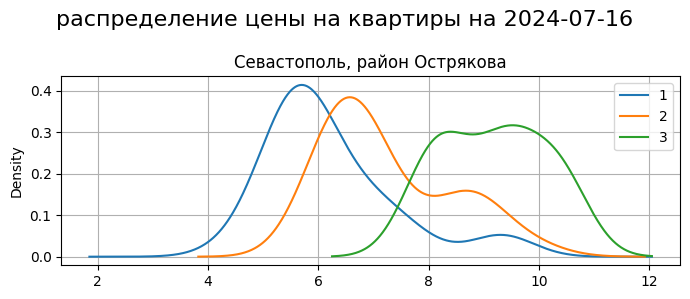

In [48]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .drop_duplicates('url')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на квартиры на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

----

In [49]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [51]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

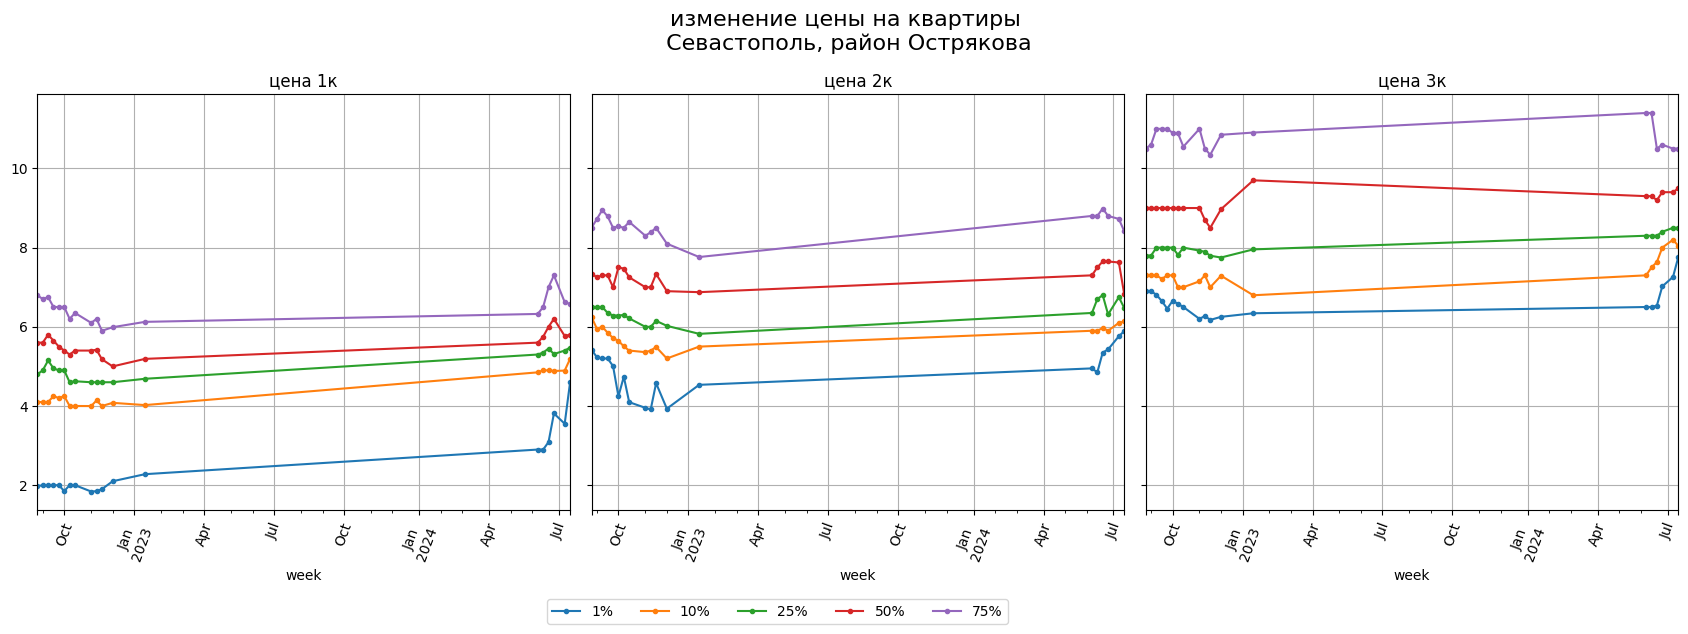

In [52]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [ ]:
# gdf_last_local

---

In [ ]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [ ]:
# df.info()

In [ ]:
# #           46.319437, 33.911048
# #
# # 45.402617, 32.455625 |  45.545301, 36.684702
# #
# #          44.320887, 33.917013

# display( len(df) )
# df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 
# display( len(df) )
# # df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

In [ ]:
# df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
# df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

# df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
# df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

# df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

# df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

# df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

# df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
# df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
# df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
# df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'

In [ ]:
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkey' 
# df.loc[ df['address']=='квартал Старый Город', 'place' ] = 'turkey' 
# df.loc[ df['address'].str.lower().str.match(r'.*село радостное.*'), 'place' ] = 'belogorsk' 

In [ ]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )